In [1]:
import pandas as pd
import numpy as np
import pymongo
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import lightgbm as ltb
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Connect to MongoDB
client = pymongo.MongoClient()
db = client.fitbitDB
collection = db.fitbitCollection

# save the documents in a dataframe
df = pd.DataFrame(list(collection.find()))

In [3]:
df = df.drop(['_id', 'id'], axis=1)

In [4]:
def modify_df(df):
    # Convert 'dateTime' column to datetime objects
    df.loc[:, 'dateTime'] = pd.to_datetime(df['data'].apply(lambda x: x['dateTime']))
    # Set 'dateTime' as the index of the DataFrame
    df.set_index('dateTime', inplace=True)
    # Extract value from data - value
    df.loc[:, 'value'] = df['data'].apply(lambda x: x['value'])
    # Drop the 'data' and 'type' columns
    df.drop(['data', 'type'], axis=1, inplace=True)

    return df

## Sleep Efficiency Prediction

In [5]:
sleep_efficiency_df = df[df['type'] == 'sleep_efficiency']
sleep_efficiency_df = modify_df(sleep_efficiency_df)
sleep_efficiency_df['value'] = sleep_efficiency_df['value'].astype(int)
sleep_efficiency_df.rename(columns={'value': 'sleep_efficiency'}, inplace=True)

In [6]:
# Resample the DataFrame to daily frequency, using the mean value for each day
efficiency_df = sleep_efficiency_df.resample('D').mean()

In [7]:
# Shift the 'sleep_efficiency' column by 7 days to create the target column
efficiency_df['target'] = efficiency_df['sleep_efficiency'].shift(-7)

In [8]:
# Drop any rows with missing values
efficiency_df.dropna(inplace=True)

In [9]:
# Split the data into training and testing sets
X = efficiency_df[['sleep_efficiency']]
y = efficiency_df['target']
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    # Train a linear regression model on the training set
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Use the trained model to make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    # Print the mean squared error
    print('Mean Squared Error:', mse)
    

Mean Squared Error: 1.4375000000000173
Mean Squared Error: 0.32835746875620364
Mean Squared Error: 2.2847072241500435
Mean Squared Error: 0.8606484235573972
Mean Squared Error: 0.6739336261930804


In [10]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train a random forest regressor model on the training set
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Use the trained model to make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    # Print the mean squared error
    print('Mean Squared Error:', mse)

Mean Squared Error: 0.14985277777776618
Mean Squared Error: 0.7370753176020339
Mean Squared Error: 2.632094600694437
Mean Squared Error: 0.5286678652761715
Mean Squared Error: 1.9814287605640906


In [11]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Train a support vector regression model on the training set
    model = SVR(kernel='rbf', gamma='auto', C=1.0, epsilon=0.1)
    model.fit(X_train_std, y_train)
    
    # Use the trained model to make predictions on the testing set
    y_pred = model.predict(X_test_std)
    
    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    # Print the mean squared error
    print('Mean Squared Error:', mse)

Mean Squared Error: 0.6268472583105142
Mean Squared Error: 0.7951883572149991
Mean Squared Error: 2.1823746667315604
Mean Squared Error: 0.7102389824100943
Mean Squared Error: 1.925225187006336


In [12]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train a gradient boosting regressor model on the training set
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    # Use the trained model to make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    # Print the mean squared error
    print('Mean Squared Error:', mse)

Mean Squared Error: 0.4999535191834454
Mean Squared Error: 1.4999302773530931
Mean Squared Error: 3.055503909194571
Mean Squared Error: 0.5862503986582212
Mean Squared Error: 2.0458773194949247


## Steps Prediction

In [13]:
steps_df = df[df['type'] == 'steps']
steps_df = modify_df(steps_df)
steps_df['value'] = steps_df['value'].astype(int)
steps_df.rename(columns={'value': 'steps'}, inplace=True)

In [14]:
# Save the dataframe to a CSV file
#steps_df.to_csv('steps.csv', index=True)

In [15]:
minutesSedentary_df = df[df['type'] == 'minutesSedentary']
minutesSedentary_df = modify_df(minutesSedentary_df)
minutesSedentary_df['value'] = minutesSedentary_df['value'].astype(int)
minutesSedentary_df.rename(columns={'value': 'minutes_sedentary'}, inplace=True)

In [16]:
minutesLightlyActive_df = df[df['type'] == 'minutesLightlyActive']
minutesLightlyActive_df = modify_df(minutesLightlyActive_df)
minutesLightlyActive_df['value'] = minutesLightlyActive_df['value'].astype(int)
minutesLightlyActive_df.rename(columns={'value': 'minutes_lightly_active'}, inplace=True)

In [17]:
minutesFairlyActive_df = df[df['type'] == 'minutesFairlyActive']
minutesFairlyActive_df = modify_df(minutesFairlyActive_df)
minutesFairlyActive_df['value'] = minutesFairlyActive_df['value'].astype(int)
minutesFairlyActive_df.rename(columns={'value': 'minutes_fairly_active'}, inplace=True)

In [18]:
minutesVeryActive_df = df[df['type'] == 'minutesVeryActive']
minutesVeryActive_df = modify_df(minutesVeryActive_df)
minutesVeryActive_df['value'] = minutesVeryActive_df['value'].astype(int)
minutesVeryActive_df.rename(columns={'value': 'minutes_very_active'}, inplace=True)

In [19]:
final_df = pd.concat([minutesSedentary_df,minutesLightlyActive_df,minutesFairlyActive_df,minutesVeryActive_df,steps_df], axis=1)
#print(final_df)

In [20]:
# Save the dataframe to a CSV file
#final_df.to_csv('data.csv', index=True)

In [21]:
#create hour, day and month variables from datetime index
steps_df['day'] =steps_df.index.day
steps_df['month'] = steps_df.index.month


In [22]:
def train_time_series_with_folds(df, horizon=21):
    X = df.drop('steps', axis=1)
    y = df['steps']    

    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
   
    #create, train and do inference of the model
    model = ltb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

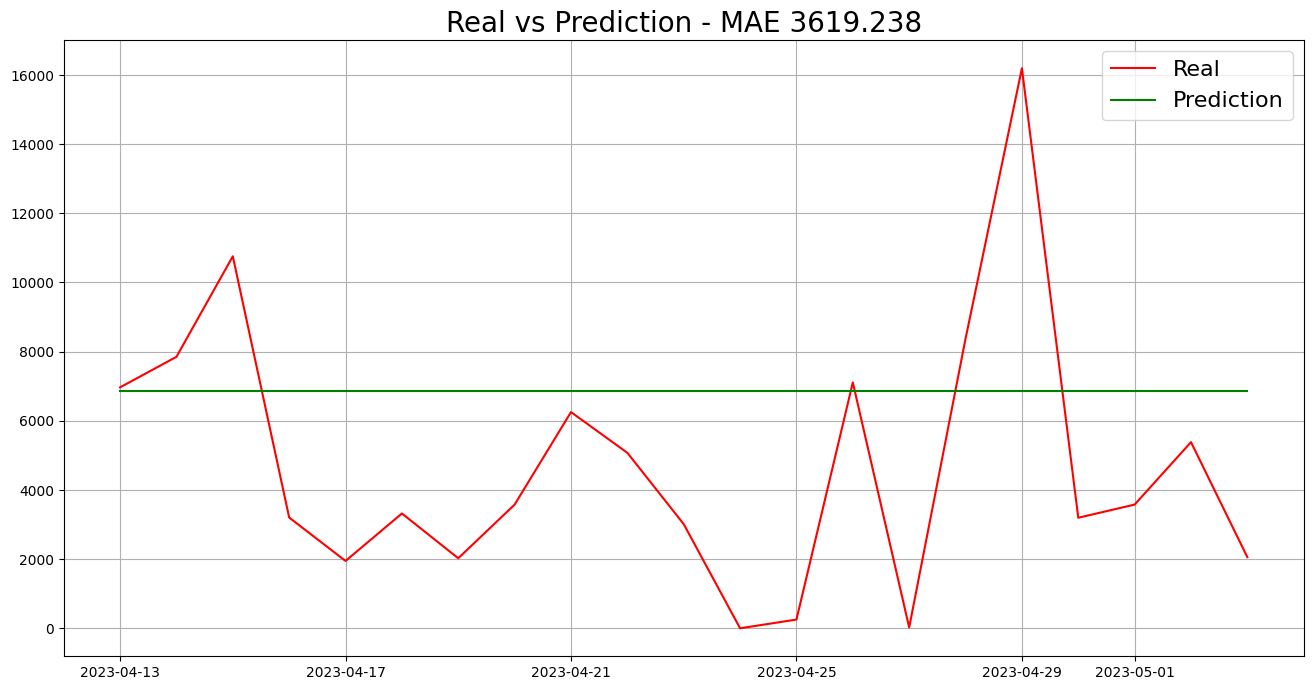

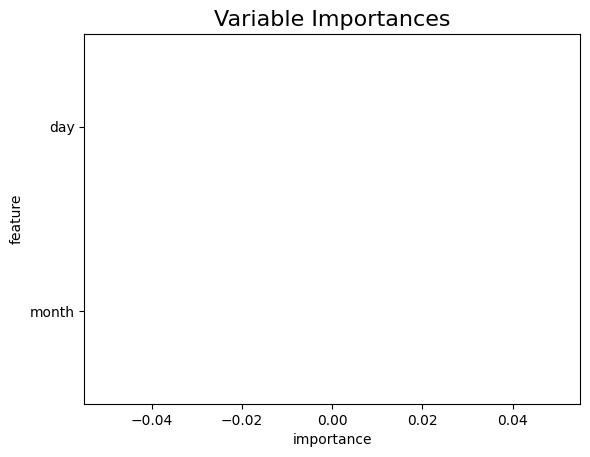

In [23]:
train_time_series_with_folds(steps_df, horizon=21)

In [24]:
# Load the data
df = pd.read_csv('data.csv', index_col='dateTime', parse_dates=True)


# Define X and y
X = df.drop('steps', axis=1)
y = df['steps']

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the time series split
tscv = TimeSeriesSplit(n_splits=5)

# Train the model and make predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

RMSE: 1839.0727786305793
RMSE: 1566.6362947985087
RMSE: 577.3132594181428
RMSE: 871.7588800580124
RMSE: 2578.8539553569144


## Time Series Forecasting - Steps

In [25]:
# Load the data
df = pd.read_csv('steps.csv', index_col='dateTime', parse_dates=True)

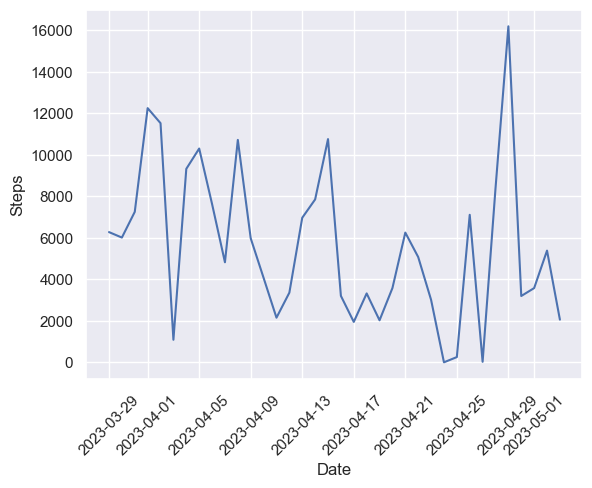

In [26]:

sns.set()

plt.ylabel('Steps')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.plot(df.index, df['steps'], )

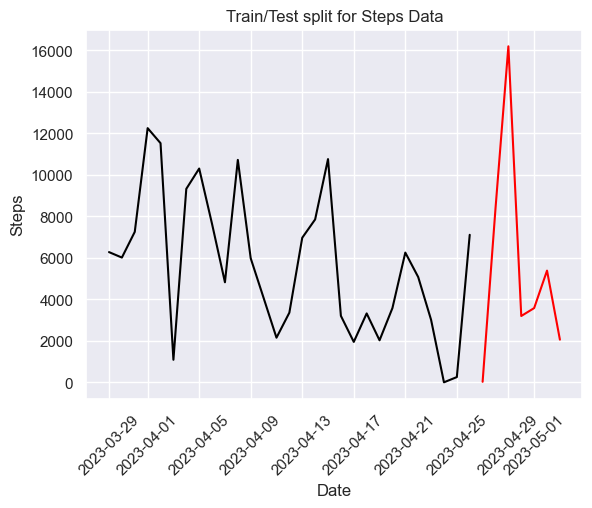

In [27]:
train = df[df.index <= pd.to_datetime("2023-04-26", format='%Y-%m-%d')]
test = df[df.index > pd.to_datetime("2023-04-26", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Steps')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Steps Data")
plt.show()

RMSE:  5363.284566440454


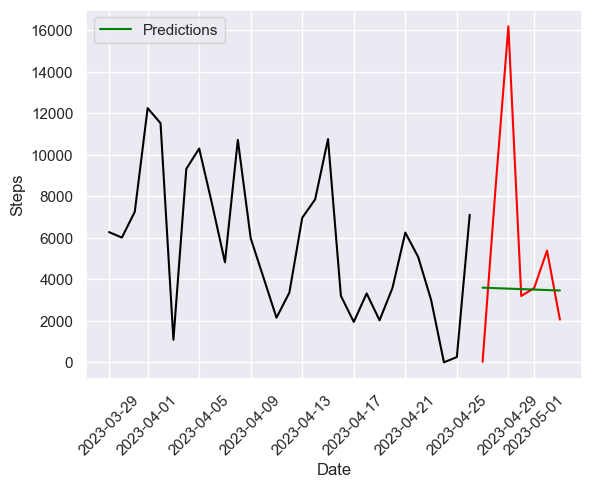

In [28]:
y = train['steps']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 


plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Steps')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test["steps"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

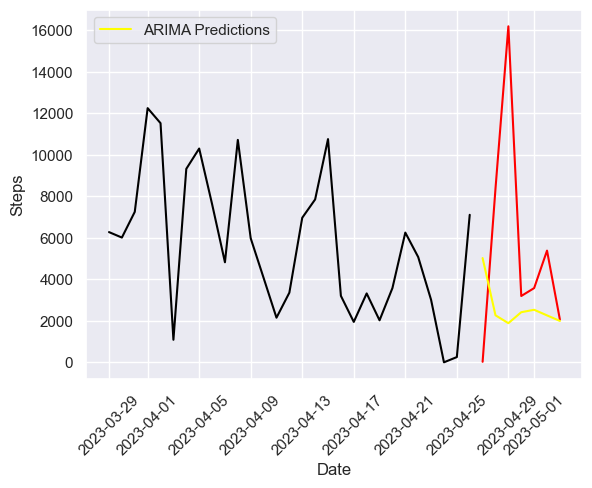

RMSE:  6307.463207971962


In [29]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 


plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Steps')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()


arma_rmse = np.sqrt(mean_squared_error(test["steps"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)